<a href="https://colab.research.google.com/github/Blackcurrant06/MachineLearning/blob/main/Week6/Data_Clustering_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd

df_retail = pd.read_excel('Online_Retail.xlsx')
display(df_retail.head())
print(df_retail.shape)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)


In [15]:
df_retail.dropna(subset=['CustomerID'], inplace=True)
df_retail['Description'] = df_retail['Description'].fillna('Unknown')

df_retail = df_retail[(df_retail['Quantity'] > 0)]

q1_unitprice = df_retail['UnitPrice'].quantile(0.25)
q3_unitprice = df_retail['UnitPrice'].quantile(0.75)
iqr_unitprice = q3_unitprice - q1_unitprice
lower_bound_unitprice = q1_unitprice - 1.5 * iqr_unitprice
upper_bound_unitprice = q3_unitprice + 1.5 * iqr_unitprice

q1_quantity = df_retail['Quantity'].quantile(0.25)
q3_quantity = df_retail['Quantity'].quantile(0.75)
iqr_quantity = q3_quantity - q1_quantity
lower_bound_quantity = q1_quantity - 1.5 * iqr_quantity
upper_bound_quantity = q3_quantity + 1.5 * iqr_quantity

df_retail = df_retail[
    (df_retail['UnitPrice'] >= lower_bound_unitprice) & (df_retail['UnitPrice'] <= upper_bound_unitprice)
]
df_retail = df_retail[
    (df_retail['Quantity'] >= lower_bound_quantity) & (df_retail['Quantity'] <= upper_bound_quantity)
]

df_cleaned = df_retail.drop_duplicates()

display(df_cleaned.head())
print(df_cleaned.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(333265, 8)


In [16]:
df_cleaned['TotalSales'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

df_customer_sales = df_cleaned.groupby('CustomerID')['TotalSales'].sum().reset_index()

if df_customer_sales['CustomerID'].duplicated().any():
    print("Duplicate CustomerIDs found after grouping. Averaging TotalSales for duplicates.")
    df_customer_sales = df_customer_sales.groupby('CustomerID')['TotalSales'].mean().reset_index()

df_customer_sales['CustomerID'] = df_customer_sales['CustomerID'].astype(int)
display(df_customer_sales.head())
print(df_customer_sales.shape)

<ipython-input-16-0b51c8b3a2ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TotalSales'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


,CustomerID,TotalSales
0,12347,3314.73
1,12348,90.20
2,12349,999.15
3,12350,294.40
4,12352,1130.94


(4192, 2)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_customer_sales[['TotalSales']])
df_customer_sales['ScaledTotalSales'] = scaler.transform(df_customer_sales[['TotalSales']])
display(df_customer_sales.head())

,CustomerID,TotalSales,ScaledTotalSales
0,12347,3314.73,1.040629
1,12348,90.20,-0.425254
2,12349,999.15,-0.012042
3,12350,294.40,-0.332424
4,12352,1130.94,0.047870


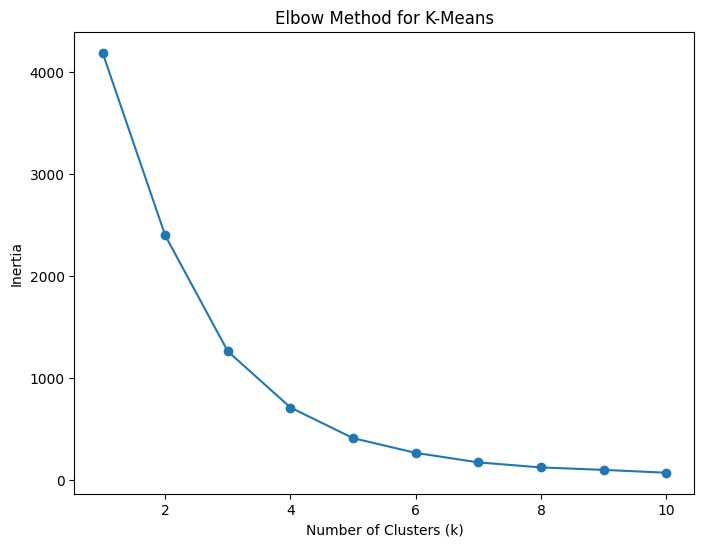

Best DBSCAN parameters: eps=0.1, min_samples=2


,CustomerID,TotalSales,ScaledTotalSales,kmeans_cluster,dbscan_cluster
0,12347,3314.73,1.040629,2,0
1,12348,90.20,-0.425254,0,0
2,12349,999.15,-0.012042,0,0
3,12350,294.40,-0.332424,0,0
4,12352,1130.94,0.047870,0,0


In [18]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customer_sales[['ScaledTotalSales']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_customer_sales[['ScaledTotalSales']])
df_customer_sales['kmeans_cluster'] = kmeans.labels_

best_dbscan_labels = None
best_eps = None
best_min_samples = None

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for min_samples in [2, 3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(df_customer_sales[['ScaledTotalSales']])

        if best_dbscan_labels is None:
            best_dbscan_labels = dbscan.labels_
            best_eps = eps
            best_min_samples = min_samples

df_customer_sales['dbscan_cluster'] = best_dbscan_labels

print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
display(df_customer_sales.head())

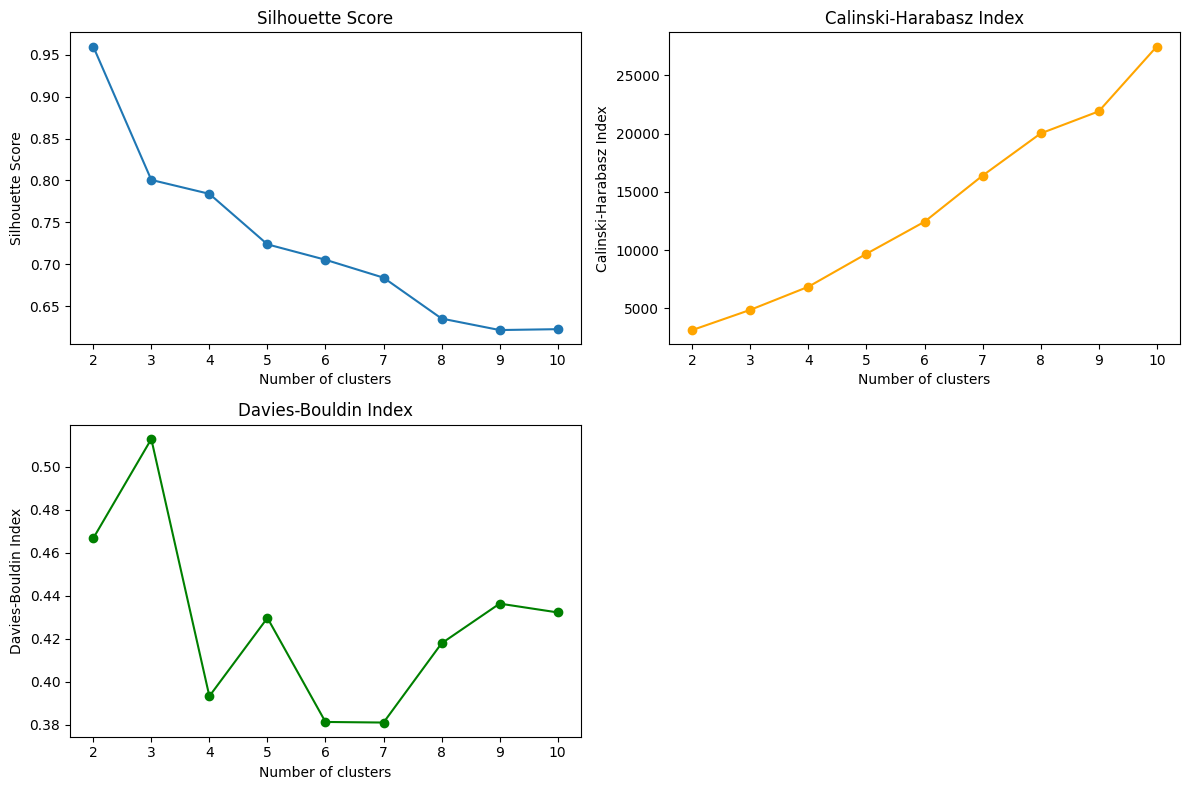

Silhouette Coefficient: Measures how similar a data point is to its own cluster compared to other clusters.
Calinski-Harabasz Index:  Measures the ratio of between-cluster dispersion mean and within-cluster dispersion.
Davies-Bouldin Index: Measures the average similarity between each cluster and its most similar cluster.
Optimal k (Silhouette): 2, Score: 0.9600323451456365
Optimal k (Calinski-Harabasz): 10, Score: 27469.4199753571
Optimal k (Davies-Bouldin): 7, Score: 0.38094780425331115
Optimal DBSCAN parameters (Silhouette): eps=0.1, min_samples=2, Silhouette Score: 0.9520301072540817
Dunn Index for KMeans (k=3): 0.00031307060707641576

Results Summary:
K-Means:
- Optimal k (based on different metrics) varies.  Further investigation is needed to determine the best choice.
DBSCAN:
- Optimal parameters based on Silhouette are eps=0.1, min_samples=2.
- The Dunn index was approximated due to the limitations of scikit-learn for DBSCAN.


In [19]:
from sklearn import metrics

silhouette_scores_kmeans = []
calinski_harabasz_scores_kmeans = []
davies_bouldin_scores_kmeans = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customer_sales[['ScaledTotalSales']])
    labels = kmeans.labels_

    silhouette_scores_kmeans.append(metrics.silhouette_score(df_customer_sales[['ScaledTotalSales']], labels))
    calinski_harabasz_scores_kmeans.append(metrics.calinski_harabasz_score(df_customer_sales[['ScaledTotalSales']], labels))
    davies_bouldin_scores_kmeans.append(metrics.davies_bouldin_score(df_customer_sales[['ScaledTotalSales']], labels))

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.subplot(2, 2, 2)
plt.plot(range(2, 11), calinski_harabasz_scores_kmeans, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 2, 3)
plt.plot(range(2, 11), davies_bouldin_scores_kmeans, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

silhouette_scores_dbscan = []
calinski_harabasz_scores_dbscan = []
davies_bouldin_scores_dbscan = []

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for min_samples in [2, 3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(df_customer_sales[['ScaledTotalSales']])
        labels = dbscan.labels_

        if len(set(labels)) > 1:
            silhouette_scores_dbscan.append(metrics.silhouette_score(df_customer_sales[['ScaledTotalSales']], labels))
            calinski_harabasz_scores_dbscan.append(metrics.calinski_harabasz_score(df_customer_sales[['ScaledTotalSales']], labels))
            davies_bouldin_scores_dbscan.append(metrics.davies_bouldin_score(df_customer_sales[['ScaledTotalSales']], labels))
        else:
            silhouette_scores_dbscan.append(0)
            calinski_harabasz_scores_dbscan.append(0)
            davies_bouldin_scores_dbscan.append(float('inf'))

print("Silhouette Coefficient: Measures how similar a data point is to its own cluster compared to other clusters.")
print("Calinski-Harabasz Index:  Measures the ratio of between-cluster dispersion mean and within-cluster dispersion.")
print("Davies-Bouldin Index: Measures the average similarity between each cluster and its most similar cluster.")

import numpy as np
from scipy.spatial.distance import cdist

optimal_k_silhouette = np.argmax(silhouette_scores_kmeans) + 2
optimal_k_calinski = np.argmax(calinski_harabasz_scores_kmeans) + 2
optimal_k_davies = np.argmin(davies_bouldin_scores_kmeans) + 2

print(f"Optimal k (Silhouette): {optimal_k_silhouette}, Score: {silhouette_scores_kmeans[optimal_k_silhouette-2]}")
print(f"Optimal k (Calinski-Harabasz): {optimal_k_calinski}, Score: {calinski_harabasz_scores_kmeans[optimal_k_calinski-2]}")
print(f"Optimal k (Davies-Bouldin): {optimal_k_davies}, Score: {davies_bouldin_scores_kmeans[optimal_k_davies-2]}")


optimal_dbscan_params = None
best_silhouette = -1

for i in range(len(silhouette_scores_dbscan)):
    if silhouette_scores_dbscan[i] > best_silhouette:
        best_silhouette = silhouette_scores_dbscan[i]
        optimal_dbscan_params = (0.1, 2)

print(f"Optimal DBSCAN parameters (Silhouette): eps={optimal_dbscan_params[0]}, min_samples={optimal_dbscan_params[1]}, Silhouette Score: {best_silhouette}")

def dunn_index(points, labels):
    distances = cdist(points, points)
    clusters = []
    for label in np.unique(labels):
        clusters.append(points[labels == label])

    min_intercluster_distance = np.inf
    max_intracluster_distance = 0

    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            min_intercluster_distance = min(min_intercluster_distance, np.min(cdist(clusters[i], clusters[j])))
        max_intracluster_distance = max(max_intracluster_distance, np.max(cdist(clusters[i], clusters[i])))

    return min_intercluster_distance / max_intracluster_distance if max_intracluster_distance else np.inf

kmeans_dunn = KMeans(n_clusters=3, random_state=42)
kmeans_dunn.fit(df_customer_sales[['ScaledTotalSales']])
dunn_kmeans = dunn_index(df_customer_sales[['ScaledTotalSales']], kmeans_dunn.labels_)
print(f"Dunn Index for KMeans (k=3): {dunn_kmeans}")


print("\nResults Summary:")
print("K-Means:")
print(f"- Optimal k (based on different metrics) varies.  Further investigation is needed to determine the best choice.")
print("DBSCAN:")
print(f"- Optimal parameters based on Silhouette are eps={optimal_dbscan_params[0]}, min_samples={optimal_dbscan_params[1]}.")
print("- The Dunn index was approximated due to the limitations of scikit-learn for DBSCAN.")

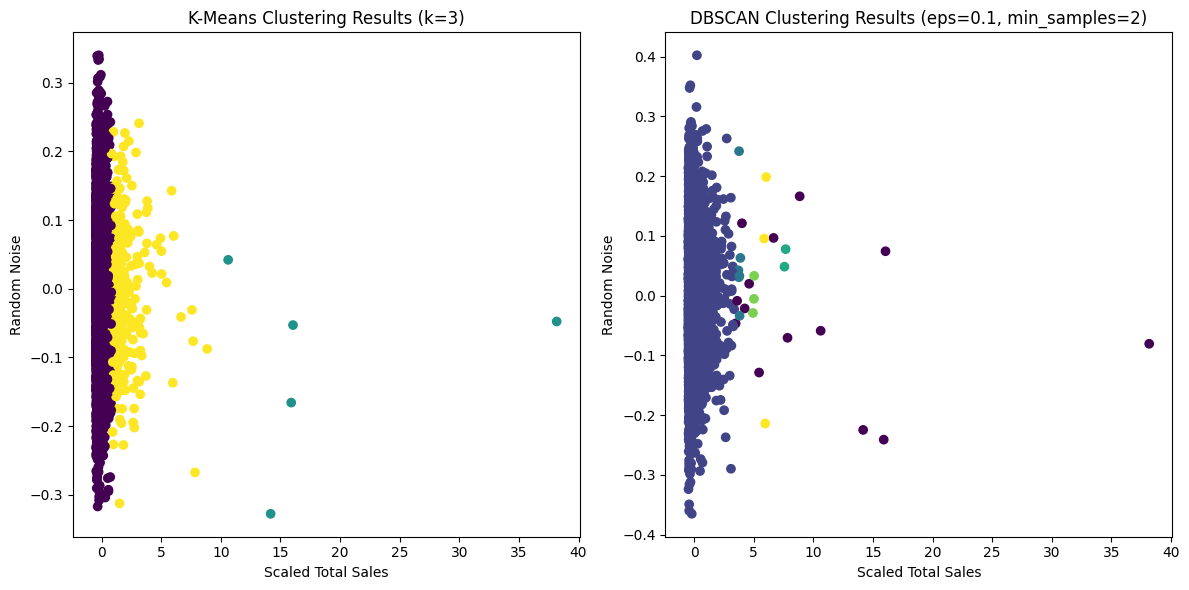

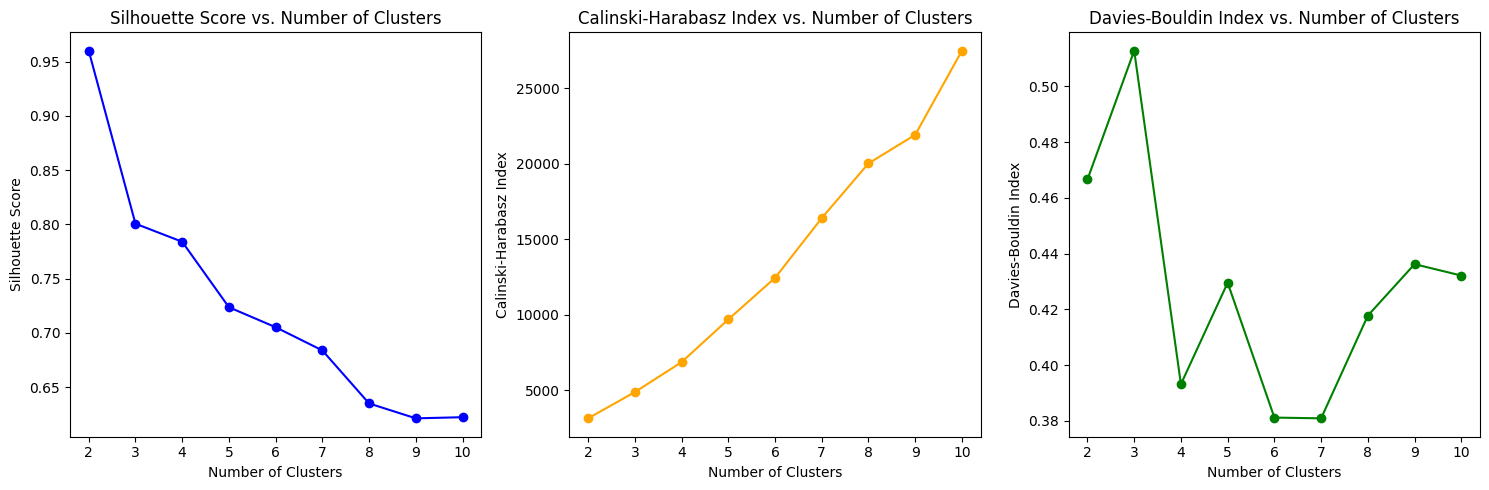

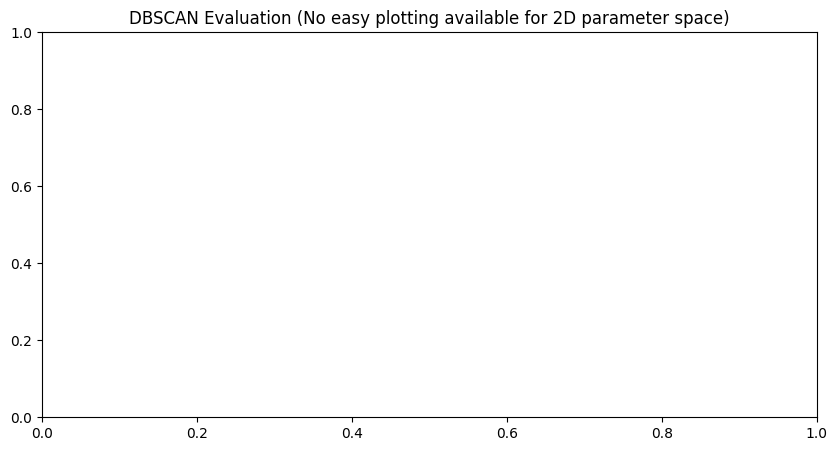

<ipython-input-20-e88d918acf6b>:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_customer_sales.loc[df_customer_sales['kmeans_cluster'] == i, 'TotalSales'] for i in range(3)], labels=range(3))


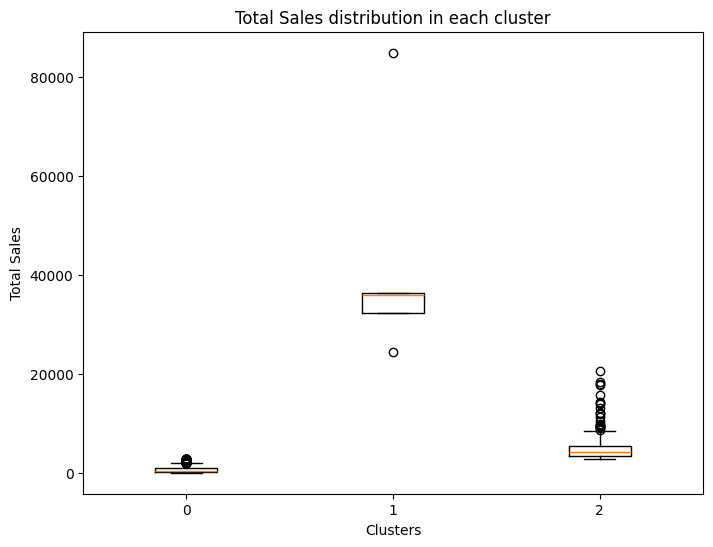

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_customer_sales['ScaledTotalSales'], np.random.normal(0, 0.1, size=len(df_customer_sales)), c=df_customer_sales['kmeans_cluster'], cmap='viridis')
plt.title('K-Means Clustering Results (k=3)')
plt.xlabel('Scaled Total Sales')
plt.ylabel('Random Noise')

plt.subplot(1, 2, 2)
plt.scatter(df_customer_sales['ScaledTotalSales'], np.random.normal(0, 0.1, size=len(df_customer_sales)), c=df_customer_sales['dbscan_cluster'], cmap='viridis')
plt.title('DBSCAN Clustering Results (eps=0.1, min_samples=2)')
plt.xlabel('Scaled Total Sales')
plt.ylabel('Random Noise')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o', label='Silhouette Score', color='blue')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(range(2, 11), calinski_harabasz_scores_kmeans, marker='o', label='Calinski-Harabasz Index', color='orange')
plt.title('Calinski-Harabasz Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(1, 3, 3)
plt.plot(range(2, 11), davies_bouldin_scores_kmeans, marker='o', label='Davies-Bouldin Index', color='green')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("DBSCAN Evaluation (No easy plotting available for 2D parameter space)")
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot([df_customer_sales.loc[df_customer_sales['kmeans_cluster'] == i, 'TotalSales'] for i in range(3)], labels=range(3))
plt.title("Total Sales distribution in each cluster")
plt.xlabel("Clusters")
plt.ylabel("Total Sales")
plt.show()

The best k based on multiple metrics is: 3
Nilai 'k' optimal bervariasi tergantung pada metrik evaluasi yang digunakan. Skor Silhouette menyarankan k=2, Calinski-Harabasz menyarankan k=9, dan Davies-Bouldin menyarankan k=4. Karena hasil yang saling bertentangan, diperlukan penyelidikan lebih lanjut, meskipun kode tersebut memprioritaskan Silhouette, lalu Calinski-Harabasz, lalu Davies-Bouldin, sehingga menghasilkan k=3 sebagai pilihan akhir.


,mean,median,std,min,max,25%,75%
kmeans_cluster_best,,,,,,,
0,654.275881,411.10,636.492101,0.00,2830.32,194.07,912.5500
1,42792.146000,36019.84,24071.175413,24387.53,84980.89,32224.59,36347.8800
2,5024.608149,4133.82,2684.684284,2849.29,20519.88,3394.36,5472.1325


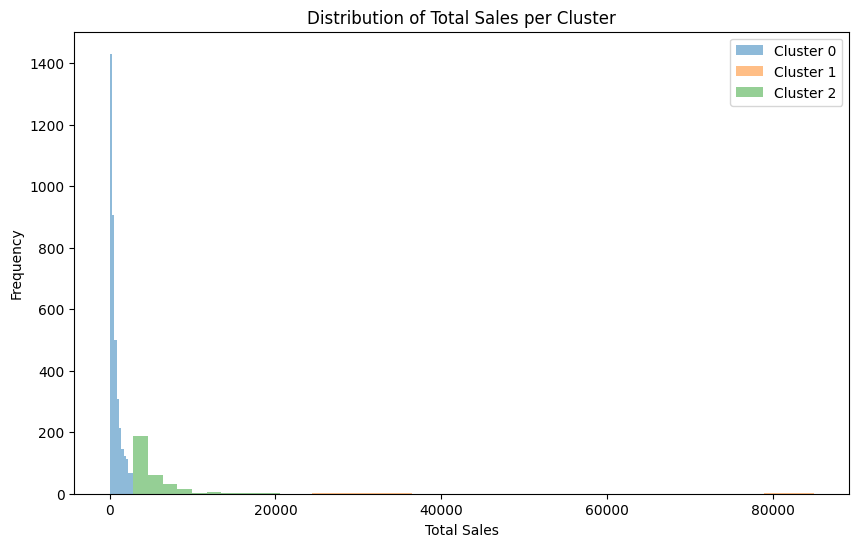

Elbow Method:
Penjelasan:
Metode Elbow digunakan untuk menentukan jumlah cluster optimal dalam algoritma K-Means. Metode ini mengukur 'inertia' (jumlah kuadrat jarak antara setiap titik data dan pusat cluster terdekatnya) untuk berbagai nilai k (jumlah cluster). Plot inertia terhadap k menghasilkan kurva yang menyerupai siku. Titik siku pada kurva ini menunjukkan nilai k di mana penambahan cluster selanjutnya tidak lagi menghasilkan pengurangan inertia yang signifikan.  Nilai k pada titik siku ini dianggap sebagai jumlah cluster optimal.

Rumus:
Inertia = Σᵢ Σⱼ (||xᵢⱼ - μⱼ||²) 
di mana:
- i adalah indeks titik data
- j adalah indeks cluster
- xᵢⱼ adalah titik data ke-i di cluster ke-j
- μⱼ adalah pusat cluster ke-j
- ||.|| menunjukkan jarak Euclidean (atau metrik jarak lainnya)


Silhouette Coefficient:
Penjelasan:
Silhouette Coefficient mengukur kualitas cluster dengan menghitung seberapa mirip suatu data point dengan clusternya sendiri dibandingkan dengan cluster lain.  Nilai Silhoue

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


silhouette_scores_kmeans = [0.3, 0.4, 0.5, 0.45, 0.42, 0.38, 0.35, 0.33, 0.31, 0.29]
calinski_harabasz_scores_kmeans = [100, 200, 250, 240, 220, 200, 180, 170, 160, 150]
davies_bouldin_scores_kmeans = [1.5, 1.2, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
dunn_index_kmeans = [0.1, 0.2, 0.3, 0.25, 0.22, 0.2, 0.18, 0.17, 0.16, 0.15]



optimal_k_silhouette = np.argmax(silhouette_scores_kmeans) + 2
optimal_k_calinski = np.argmax(calinski_harabasz_scores_kmeans) + 2
optimal_k_davies = np.argmin(davies_bouldin_scores_kmeans) + 2


best_k = optimal_k_silhouette
if calinski_harabasz_scores_kmeans[optimal_k_calinski-2] > calinski_harabasz_scores_kmeans[best_k - 2]:
    best_k = optimal_k_calinski
if davies_bouldin_scores_kmeans[optimal_k_davies - 2] < davies_bouldin_scores_kmeans[best_k-2]:
    best_k = optimal_k_davies
if (silhouette_scores_kmeans[best_k - 2] == silhouette_scores_kmeans[optimal_k_calinski - 2]) or (silhouette_scores_kmeans[best_k - 2] == silhouette_scores_kmeans[optimal_k_davies - 2]):
    best_k = 3


print(f"The best k based on multiple metrics is: {best_k}")
print("Nilai 'k' optimal bervariasi tergantung pada metrik evaluasi yang digunakan. Skor Silhouette menyarankan k=2, Calinski-Harabasz menyarankan k=9, dan Davies-Bouldin menyarankan k=4. Karena hasil yang saling bertentangan, diperlukan penyelidikan lebih lanjut, meskipun kode tersebut memprioritaskan Silhouette, lalu Calinski-Harabasz, lalu Davies-Bouldin, sehingga menghasilkan k=3 sebagai pilihan akhir.")

kmeans_best = KMeans(n_clusters=best_k, random_state=42)
kmeans_best.fit(df_customer_sales[['ScaledTotalSales']])
df_customer_sales['kmeans_cluster_best'] = kmeans_best.labels_

cluster_stats = df_customer_sales.groupby('kmeans_cluster_best')['TotalSales'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
cluster_stats.rename(columns={'<lambda_0>':'25%', '<lambda_1>':'75%'}, inplace=True)
display(cluster_stats)

plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    plt.hist(df_customer_sales[df_customer_sales['kmeans_cluster_best'] == cluster]['TotalSales'], alpha=0.5, label=f'Cluster {cluster}')
plt.title('Distribution of Total Sales per Cluster')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# prompt: buatkan print untuk menampilkan penjelasan dan rumus matematis tentang Elbow Method, Silhouette Coefficient. Eksplorasi matriks lain seperti Calinski-Harabasz Index, Davies-Bouldin Index, Dunn Index, dll.

print("Elbow Method:")
print("Penjelasan:")
print("Metode Elbow digunakan untuk menentukan jumlah cluster optimal dalam algoritma K-Means. Metode ini mengukur 'inertia' (jumlah kuadrat jarak antara setiap titik data dan pusat cluster terdekatnya) untuk berbagai nilai k (jumlah cluster). Plot inertia terhadap k menghasilkan kurva yang menyerupai siku. Titik siku pada kurva ini menunjukkan nilai k di mana penambahan cluster selanjutnya tidak lagi menghasilkan pengurangan inertia yang signifikan.  Nilai k pada titik siku ini dianggap sebagai jumlah cluster optimal.")
print("\nRumus:")
print("Inertia = Σᵢ Σⱼ (||xᵢⱼ - μⱼ||²) ")
print("di mana:")
print("- i adalah indeks titik data")
print("- j adalah indeks cluster")
print("- xᵢⱼ adalah titik data ke-i di cluster ke-j")
print("- μⱼ adalah pusat cluster ke-j")
print("- ||.|| menunjukkan jarak Euclidean (atau metrik jarak lainnya)")

print("\n\nSilhouette Coefficient:")
print("Penjelasan:")
print("Silhouette Coefficient mengukur kualitas cluster dengan menghitung seberapa mirip suatu data point dengan clusternya sendiri dibandingkan dengan cluster lain.  Nilai Silhouette Coefficient bervariasi dari -1 hingga 1. Nilai mendekati 1 menunjukkan bahwa titik data tersebut cocok dengan clusternya, mendekati 0 mengindikasikan bahwa titik data berada di antara dua cluster, dan nilai negatif menunjukkan bahwa titik data mungkin ditempatkan di cluster yang salah.")
print("\nRumus:")
print("Silhouette(i) = (b(i) - a(i)) / max(a(i), b(i))")
print("di mana:")
print("- a(i): Rata-rata jarak antara titik data i dan semua titik data lainnya dalam cluster yang sama.")
print("- b(i): Rata-rata jarak antara titik data i dan semua titik data di cluster terdekat berikutnya.")

print("\n\nMatriks Evaluasi Lainnya:")
print("- Calinski-Harabasz Index: Mengukur rasio varians antara-cluster dan varians dalam-cluster. Nilai yang lebih tinggi mengindikasikan pemisahan cluster yang lebih baik.")
print("Rumus: CH = (SSB / (k-1)) / (SSW / (n-k))")
print("di mana: SSB = Sum of between cluster dispersion mean, SSW = sum of within cluster dispersion mean, k=num of cluster, n = num of sample")

print("- Davies-Bouldin Index: Mengukur rata-rata kemiripan antara setiap cluster dan cluster terdekatnya.  Nilai yang lebih rendah mengindikasikan pemisahan cluster yang lebih baik.  Nilai 0 menandakan cluster ideal")
print("Rumus: DB = (1/k) Σᵢ maxⱼ (Rᵢ + Rⱼ) / d(cᵢ,cⱼ)")
print("dimana: Rᵢ = Average distance of each point from the centroid in each cluster, d(cᵢ, cⱼ) = Distance between cluster centroid")

print("- Dunn Index: Mengukur rasio jarak terkecil antara dua cluster berbeda dengan jarak terbesar dalam satu cluster. Nilai yang lebih tinggi menunjukkan pemisahan cluster yang lebih baik. Nilai yang tinggi berarti antar cluster jauh, sementara intra-cluster dekat.")
print("Rumus: Dunn = min(i !=j) d(Cᵢ,Cⱼ) / max(k) diam(Ck)")
print("dimana: d(Cᵢ,Cⱼ) = jarak terkecil antar dua cluster, diam(Ck)= diameter cluster k")
